In [1]:
import dicom
from os import path
import pydicom

/Users/fonturacetamum/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [18]:
from matplotlib import pyplot as plt
plt.set_cmap("gray")

%matplotlib inline

In [ ]:
TAKE:
    387719 MRI (CT?)
    387098 MRI
    386800 MRI
    386662 MRI (shift)
    386661 CT (MRT shift)

DROP:  
  387098

In [ ]:
!ls ../data/387098/

In [325]:
GOOD_EXAMPLES = [
    (385185, "MR_1"),
    (385948, "MR_1"),
    (386348, "MR_1"),
    (387295, "MR_1"),
    (353891, "MR_1"),
    (361113, "MR_0809"),
    (363740, "MR_1"),
    (380677, "MR_1"),
    (387719, "MR_1")
]

In [331]:
mr_images[0].pixel_array.shape

(256, 168)

In [336]:
dicom.read_file("../data/{}/RS.{}.{}.dcm".format(current_id, current_id, plan)).pixel_array

(361113, 'MR_0809')

In [338]:
Xs = []
Ys = []

for example in GOOD_EXAMPLES:
    current_id, plan = example

    plan = dicom.read_file("../data/{}/RS.{}.{}.dcm".format(current_id, current_id, plan))

    uid_contour_dict = dict()
    for roi in plan.ROIContourSequence:
        for contour in roi.get("ContourSequence", []):
            assert len(contour.ContourImageSequence) == 1
            cur_uid = contour.ContourImageSequence[0].ReferencedSOPInstanceUID
            uid_contour_dict[cur_uid] = contour.ContourData

    PREFIX = "../data/{}/".format(current_id)
    filenames = !ls $PREFIX

    uid_filename_dict = dict()
    for filename in filenames:
        dicom_image = dicom.read_file(path.join(PREFIX, filename))
        uid_filename_dict[dicom_image.SOPInstanceUID] = filename
        
    mr_image_filenames = [v for v in uid_filename_dict.values() if "MR" in v and "MR_" not in v]
    mr_images = [dicom.read_file(path.join(PREFIX, f)) for f in mr_image_filenames]
    mr_images = sorted(mr_images, key=slice_loc_safe)
    
    images_list = mr_images
    
    if len(set([img.pixel_array.shape for img in images_list])) != 1:
        print(example)
        continue
    
    masks_list = []

    cur_x = np.zeros((len(mr_images), mr_images[0].pixel_array.shape[0], mr_images[0].pixel_array.shape[1]))
    cur_y = np.zeros((len(mr_images), mr_images[0].pixel_array.shape[0], mr_images[0].pixel_array.shape[1]))

    for IDX in range(len(images_list)):
        dicom_image = images_list[IDX]
        cur_x[IDX] = dicom_image.pixel_array
        mask = np.zeros_like(dicom_image.pixel_array)
        scale_x = scale_y = 1
        shift_x = shift_y = shift_z = 0

        if dicom_image.get("PixelSpacing") is None:
            print("No Pixel spacing")

        if dicom_image.get("ImagePositionPatient") is None:
            print("No position")

        scale_x, scale_y = dicom_image.get("PixelSpacing", [scale_x, scale_y])
        shift_x, shift_y, shift_z = dicom_image.get("ImagePositionPatient", [shift_x, shift_y, shift_z])

        if images_list[IDX].SOPInstanceUID in uid_contour_dict:
            contour_data = uid_contour_dict[images_list[IDX].SOPInstanceUID]

            xs = np.array(contour_data[::3]) - shift_x
            ys = np.array(contour_data[1::3]) - shift_y


            xs /= scale_x
            ys /= scale_y

            poly_idx = draw.polygon(ys, xs, shape=mask.shape)
            mask[poly_idx[0], poly_idx[1]] = 1

            zs = contour_data[2::3]

        cur_y[IDX] = mask
        
    Xs.append(cur_x)
    Ys.append(cur_y)

(386348, 'MR_1')


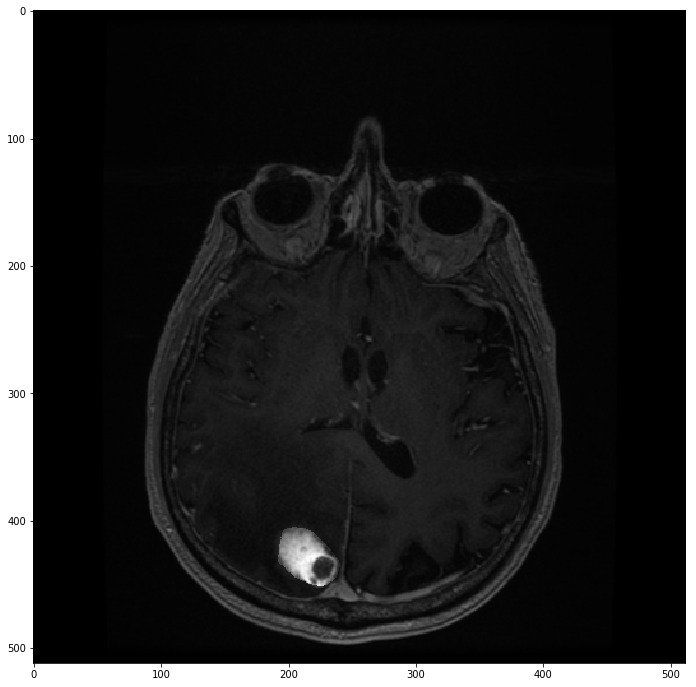

In [351]:
ALPHA = .4
PATIENT = 0
IDX = 36

plt.figure(figsize=(12, 12))
plt.imshow(Xs[PATIENT][IDX] * ALPHA + (1 - ALPHA) * Ys[PATIENT][IDX] * Xs[PATIENT][IDX])

In [350]:
Ys[PATIENT].sum()

24210.0

In [335]:
images_list

[(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008, 0012) Instance Creation Date              DA: '20181018'
(0008, 0013) Instance Creation Time              TM: '070256'
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.8.2.0.20170810112221617379268153294.26725588352
(0008, 0020) Study Date                          DA: '20170809'
(0008, 0021) Series Date                         DA: '20170809'
(0008, 0022) Acquisition Date                    DA: '20170810'
(0008, 0023) Content Date                        DA: '20170809'
(0008, 0030) Study Time                          TM: '101946'
(0008, 0031) Series Time                         TM: '102022'
(0008, 0032) Acquisition Time                    TM: '115112.763'
(0008, 0033) Content Time                        TM: '102023'
(0008, 0050) Accession Num

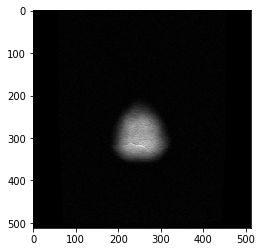

In [328]:
plt.imshow(dicom_image.pixel_array)

In [329]:
cur_x.shape

(183, 256, 168)

In [284]:
def slice_loc_safe(img):
    try:
        return -img.SliceLocation
    except AttributeError:
        return 1000000

mr_image_filenames = [v for v in uid_filename_dict.values() if "MR" in v and "MR_1" not in v]
mr_images = [dicom.read_file(path.join(PREFIX, f)) for f in mr_image_filenames]
mr_images = sorted(mr_images, key=slice_loc_safe)

In [170]:
ct_image_filenames = [v for v in uid_filename_dict.values() if "CT" in v and "0001" not in v]
ct_images = [dicom.read_file(path.join(PREFIX, f)) for f in ct_image_filenames]
ct_images = sorted(ct_images, key=slice_loc_safe)

In [193]:
[img.SOPInstanceUID for img in ct_images if img.SOPInstanceUID in uid_contour_dict]

['1.3.12.2.1107.5.1.4.64713.30000017060806450296200004433',
 '1.3.12.2.1107.5.1.4.64713.30000017060806450296200004434',
 '1.3.12.2.1107.5.1.4.64713.30000017060806450296200004435',
 '1.3.12.2.1107.5.1.4.64713.30000017060806450296200004436',
 '1.3.12.2.1107.5.1.4.64713.30000017060806450296200004437',
 '1.3.12.2.1107.5.1.4.64713.30000017060806450296200004438',
 '1.3.12.2.1107.5.1.4.64713.30000017060806450296200004439',
 '1.3.12.2.1107.5.1.4.64713.30000017060806450296200004440',
 '1.3.12.2.1107.5.1.4.64713.30000017060806450296200004441',
 '1.3.12.2.1107.5.1.4.64713.30000017060806450296200004424',
 '1.3.12.2.1107.5.1.4.64713.30000017060806450296200004442',
 '1.3.12.2.1107.5.1.4.64713.30000017060806450296200004443',
 '1.3.12.2.1107.5.1.4.64713.30000017060806450296200004444',
 '1.3.12.2.1107.5.1.4.64713.30000017060806450296200004445',
 '1.3.12.2.1107.5.1.4.64713.30000017060806450296200004446',
 '1.3.12.2.1107.5.1.4.64713.30000017060806450296200004447',
 '1.3.12.2.1107.5.1.4.64713.300000170608

In [148]:
IDX = 0

In [16]:
import numpy as np
from skimage import exposure

In [84]:
IDX = 55

In [96]:
len(ct_images)

171

In [246]:
IDX = 0

In [271]:
from skimage import draw

In [322]:
images_list = mr_images
masks_list = []

cur_x = np.zeros((len(mr_images), mr_images[0].pixel_array.shape[0], mr_images[0].pixel_array.shape[1]))
cur_y = np.zeros((len(mr_images), mr_images[0].pixel_array.shape[0], mr_images[0].pixel_array.shape[1]))

for IDX in range(len(images_list)):
    dicom_image = images_list[IDX]
    cur_x[IDX] = dicom_image.pixel_array
    mask = np.zeros_like(dicom_image.pixel_array)
    scale_x = scale_y = 1
    shift_x = shift_y = shift_z = 0

    if dicom_image.get("PixelSpacing") is None:
        print("No Pixel spacing")

    if dicom_image.get("ImagePositionPatient") is None:
        print("No position")

    scale_x, scale_y = dicom_image.get("PixelSpacing", [scale_x, scale_y])
    shift_x, shift_y, shift_z = dicom_image.get("ImagePositionPatient", [shift_x, shift_y, shift_z])

    if images_list[IDX].SOPInstanceUID in uid_contour_dict:
        contour_data = uid_contour_dict[images_list[IDX].SOPInstanceUID]

        xs = np.array(contour_data[::3]) - shift_x
        ys = np.array(contour_data[1::3]) - shift_y
        

        xs /= scale_x
        ys /= scale_y
        
        poly_idx = draw.polygon(ys, xs, shape=mask.shape)
        mask[poly_idx[0], poly_idx[1]] = 1

        zs = contour_data[2::3]
        
    cur_y[IDX] = mask

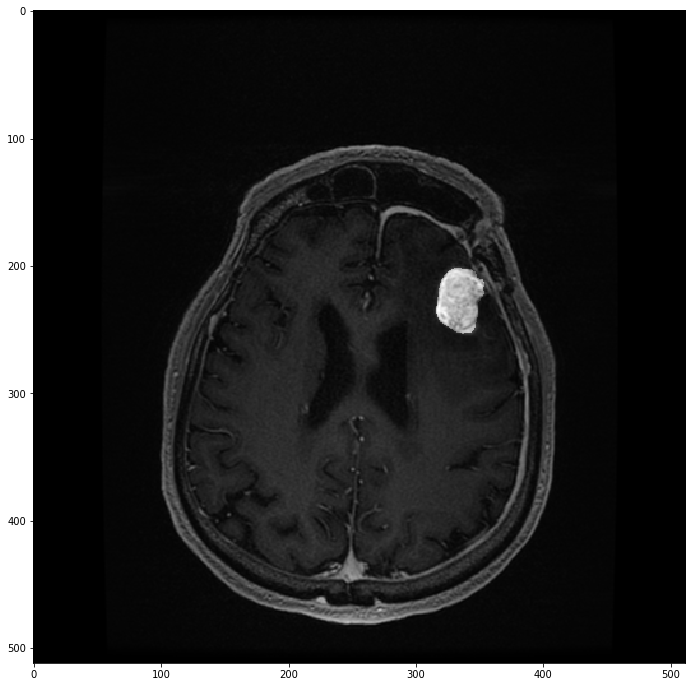

In [324]:
ALPHA = .4
IDX = 31

plt.figure(figsize=(12, 12))
plt.imshow(cur_x[IDX] * ALPHA + (1 - ALPHA) * cur_y[IDX] * cur_x[IDX])

In [266]:
IDX = 26

In [239]:
IDX

27

In [ ]:
mr_images[IDX].SOPInstanceUID

In [ ]:
IDX = 110

In [ ]:
IDX = 110

In [ ]:
dicom_image

In [ ]:
IDX = 0

In [ ]:
shift_z = 0

In [ ]:
IDX -= 5

In [ ]:
IDX = 0

In [ ]:
IDX -= 4

In [ ]:
IDX = 50

In [ ]:
IDX

In [ ]:
dicom.read_file

In [ ]:
uid_filename_dict

In [ ]:
uid_filename_dict

In [ ]:
IDX = 0

In [ ]:
plan

In [ ]:
dicom_image

In [ ]:
import numpy as np

In [ ]:
IDX = 0

In [ ]:
current_id

In [ ]:
image_name

In [ ]:
"../data/{}/{}".format(current_id, image_name)

In [ ]:
image_uid

In [ ]:
uid_filename_dict["1.3.12.2.1107.5.1.4.65763.30000017060707195877000000427"]

In [ ]:
dicom_image

In [ ]:
dicom.read_file("../data/{}/{}".format(current_id, image_name))

In [ ]:
IDX = 0

In [ ]:
"../data/{}/{}".format(current_id, image_name)

In [ ]:
dicom_images = [dicom.read_file(path.join(PREFIX, f)) for f in filenames if "CT" in f]

In [ ]:
dicom_image.ImagePositionPatient

In [ ]:
def f(img):
    try:
#         print(img.ImagePositionPatient)
        return img.SliceLocation
    except AttributeError:
        return -1000000
d_i_sorted = sorted(dicom_images, key=f, reverse=True)

In [ ]:
new_arr = np.array(d_i_sorted[48].pixel_array / d_i_sorted[48].pixel_array.max(), dtype=np.float32)

In [ ]:
from skimage import exposure

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(exposure.equalize_hist(new_arr))

In [ ]:
image_name

In [ ]:
image_uid = images_of_interest[IDX]
image_name = uid_filename_dict[image_uid]
dicom_image = dicom.read_file("../data/{}/{}".format(current_id, image_name))
image = dicom_image.pixel_array
plt.figure(figsize=(12, 12))
plt.imshow(exposure.equalize_hist(image))

contour_data = uid_contour_dict[image_uid]
scale_x, scale_y = dicom_image.PixelSpacing
shift_x, shift_y, _ = dicom_image.ImagePositionPatient
xs = np.array(contour_data[::3]) - shift_x
ys = np.array(contour_data[1::3]) - shift_y

xs /= scale_x
ys /= scale_y

zs = contour_data[2::3]

plt.plot(xs, ys)

IDX += 1

In [ ]:
seq = plan.ROIContourSequence[0]

In [ ]:
seq.RefdROINumber

In [ ]:
seq = plan.StructureSetROISequence[0]

In [ ]:
seq.ReferencedFrameOfReferenceUID

In [ ]:
one_image.ROIContourSequence[0]

In [ ]:
seq = one_image.ROIContourSequence[1]

In [ ]:
seq.keys()

In [ ]:
contour_data = seq.ContourSequence[0].ContourData

In [ ]:
plt.plot(xs, ys)

In [ ]:
plt.figure(figsize=(12, 12))
plt.set_cmap("gray")
plt.imshow(one_image.pixel_array)